In [10]:
import os
from pyuvdata import UVData
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import numpy.ma as ma

In [3]:
uv = UVData()
uv.read('/lustre/aoc/projects/hera/pstar/autos/2458745_autos_sum.uvh5')

In [4]:
print(uv.antenna_numbers)

[  0   1   2  11  12  13  14  23  24  25  26  39  84  85  86  87  89  91
 101 102 103 104 105 106 108 120 121 122 123 124 125 126]


In [5]:
freq = uv.freq_array[0]*1e-6
antnums = uv.antenna_numbers
times = np.unique(uv.time_array)

In [442]:
#this function will be helpful in testing the mask

def auto_waterfall_lineplot (ant,colorbar_min, colorbar_max):
    
    freq = uv.freq_array[0]*1e-6
    fig = plt.figure(figsize=(20,20))

    #can use gridspec instead of saying add_subplot(1,2,1) etc
    gs = gridspec.GridSpec(2, 1, height_ratios=[2,1]) 

    #creates waterfall subplot
    waterfall= plt.subplot(gs[0])
        
    #create time axis
    jd_ax=plt.gca()

    #there are a lot of redundancies in time_array, so to make sure that we have a list
    #of unique times to work with, we start off by making a new array... not doing this will
    #make things get messy. gave me a blank plot at first with a bunch of lines on the side
    #before i did this.
    times= np.unique(uv.time_array)

    #create the plot. uv.get_data will get data from specified antennas
    #colors.LogNorm() puts colors on log scale
    im = plt.imshow(np.abs(uv.get_data((ant,ant, uv.polarization_array[0]))),norm=colors.LogNorm(), 
                vmin=colorbar_min, vmax=colorbar_max, aspect='auto')
    waterfall.set_title('Waterfall+Lineplot, Antenna '+str(ant))

    # get an array of frequencies in MHz
    freqs = uv.freq_array[0, :] / 1000000
    xticks = np.arange(0, len(freqs), 120)
    plt.xticks(xticks, labels =np.around(freqs[xticks],2))

    jd_ax.set_ylabel('JD Time (days)')

    #makes equally spaced ticks in increments of 100. since we are assuming time is pretty
    #continuous, this will cover all times pretty well if we go from 0 to the length 
    jd_yticks = np.arange(0,len(times),100)
    #set_yticks takes a List of y-axis tick locations. its purpose is to set tick locations
    jd_ax.set_yticks(jd_yticks)
    #this function actually determines what the tickmarks will say.
    jd_ax.set_yticklabels(np.around(times[jd_yticks],2))


    #create second axis
    lst_ax = jd_ax.twinx()
    lst_ax.set_ylabel('LST Time (hour of the day)')

    #lst_array is in radians, and we want it in *hours*.. rad*180/pi = degrees
    #one hour= 15 degrees
    lst_hours = (uv.lst_array*(180/np.pi))/(15)

    #creates array of unique lsts
    lsts= lst_hours.reshape(uv.Ntimes,uv.Nbls)
    lsts = lsts[:,0]

    #set the ticks of the lst axis to match the lst_array in hours
    lst_yticks = np.arange(0,len(lsts),100)
    lst_ax.set_yticks(lst_yticks)
    lst_ax.set_yticklabels(np.around(lsts[lst_yticks],2))

    #gives the lst_axis information about the jd_axis. stuff like the y-dimension of the data. 
    #gets the axes to line up properly. will make it so that the tick-marks lining up, and the 
    #zeroth entry of times[jd_yticks] lining up with the zeroth entry of lsts[lst_yticks]
    lst_ax.set_ylim(jd_ax.get_ylim())

    #makes it so that the second axis does not alter the structure of the figure
    jd_ax.autoscale(False)
    lst_ax.autoscale(False)

    #creates line subplot and positions it according to gs[1]
    line= plt.subplot(gs[1])

    averaged_data= np.abs(np.average(uv.get_data((1,1, uv.polarization_array[0])),0))

    plt.plot(freq,averaged_data)
    line.set_yscale('log')
    line.set_xlabel('Frequency (MHz)')
    line.set_ylabel('Power')
    #sets the range of the graph to be the same range as waterfall plot
    line.set_xlim(freq[0],freq[-1])


    #makes waterfall x ticks invisible
    plt.setp(waterfall.get_xticklabels(), visible=False)

    #brings plots together
    plt.subplots_adjust(hspace=.0)


    #pad moves colorbar farther from plot
    cbar = plt.colorbar(im, pad= 0.15, orientation = 'horizontal')
    cbar.set_label('Power -->')
        
    #plt.savefig('/lustre/aoc/projects/hera/amyers/gitrepos/monsterDetection/waterfalls/'+
    #                'WF_LP_ant'+str(ant))
    #plt.show()
    #plt.close()


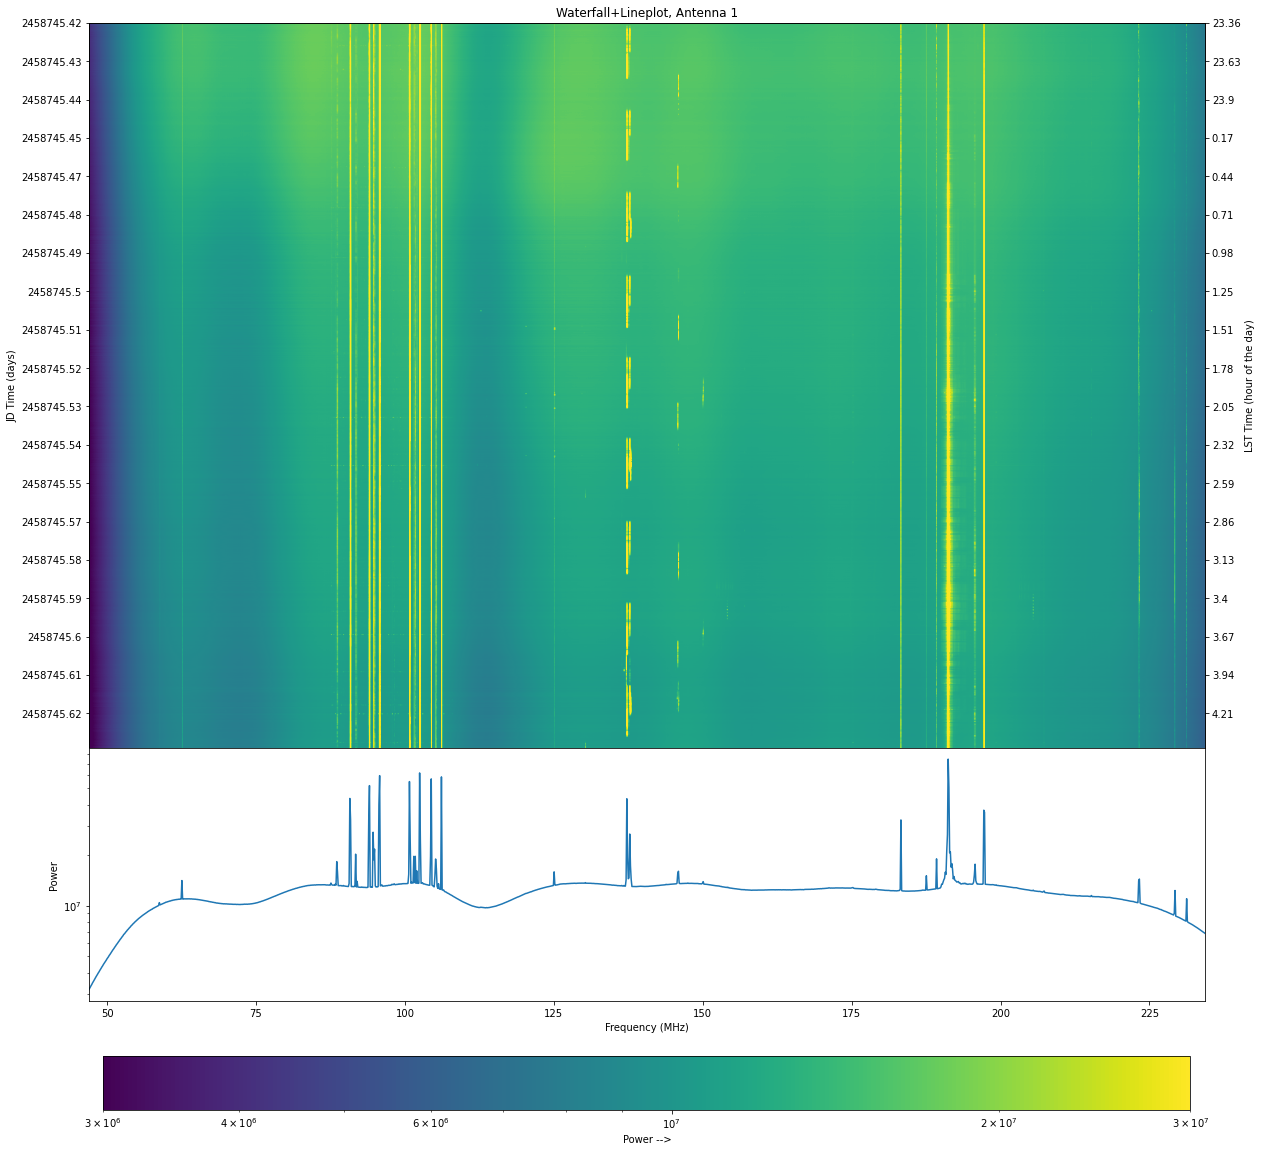

In [444]:
auto_waterfall_lineplot(1,0.3*10e6, 0.3*10e7)

In [44]:
#getting familiar with data_array shape
#data_array.shape gives (rows,columns). to specify a row, do data_array[row]. To specify a 
#value in a column, do data_array[row, column]. can select entire column with [:,column]
#column of data array is freq. row is time

data_array = np.abs(uv.get_data((1, 1, uv.polarization_array[0])))
print(data_array.shape)
print(data_array[0])
print(data_array[1])
print(data_array[2])
print(data_array[3])
print(data_array[4])
print(data_array[1800])
print(data_array[1889])
print(data_array[:,1])

(1890, 1536)
[4147026. 4243306. 4298776. ... 7816560. 7764941. 7692112.]
[4174787. 4272742. 4325300. ... 7820975. 7771043. 7708261.]
[4073516. 4163459. 4231266. ... 7787784. 7726570. 7658732.]
[4121021. 4223259. 4273815. ... 7804533. 7745286. 7665661.]
[4031452. 4138341. 4205227. ... 7797682. 7760943. 7642191.]
[2753948. 2800851. 2845181. ... 6156933. 6114147. 6075314.]
[2784338. 2848880. 2886451. ... 6224918. 6172219. 6119377.]
[4243306. 4272742. 4163459. ... 2884094. 2838901. 2848880.]


In [434]:
#creating mask (we create a mask for things we WANT, ie. places that aren't spikes)

data_array = np.abs(uv.get_data((1, 1, uv.polarization_array[0])))

#identifies columns that i want to mask out
idx = np.array([128,
                333,341,342,358,359,360,367,369,385,386,391,392,393,399,
                400,440,441,442,447,449,451,455,456,470,471,476,477,478,481,485,
                640,
                739,740,741,742,743,744,745,746,
                810,811,844,845,
                1117,1152,1166,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,
                    1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,
                    1195,1196,1197,1198,1199,
                1218,1219,1220,1231,1232,
                1444,1445,1493,1494,
                1510])

#creates masking array
spike_mask = np.zeros_like(data_array)

#tells the array which values to set to 1 (which values to mask out)
spike_mask[:,idx]= 1

#makes masked array without undesired values
masked_data = ma.masked_array(data_array, spike_mask)

In [435]:
powers_avg= ma.mean(masked_data,0)
#print(masked_data.shape)
#print(masked_data[0,range(600,651)])
print(powers_avg[range(1500,1535)])

[8487611.811111111 8446392.557142857 8407774.621164022 8360279.87037037
 8310434.955026455 8259349.349206349 8217573.246560846 8179571.2597883595
 8134706.96031746 8096999.094179894 -- 8064376.161904762 7960977.173544973
 7919127.7989417985 7873393.516402116 7832722.785714285 7786763.482010582
 7747161.814285714 7700543.062962963 7647546.771428571 7597439.126455027
 7550753.997354497 7506019.119047619 7459229.235449735 7407402.814285714
 7361880.8513227515 7309940.347089947 7260167.673015873 7207972.372486773
 7157678.335449736 7111496.580952381 7059609.873015873 7013611.44973545
 6964137.1846560845 6909084.35978836]


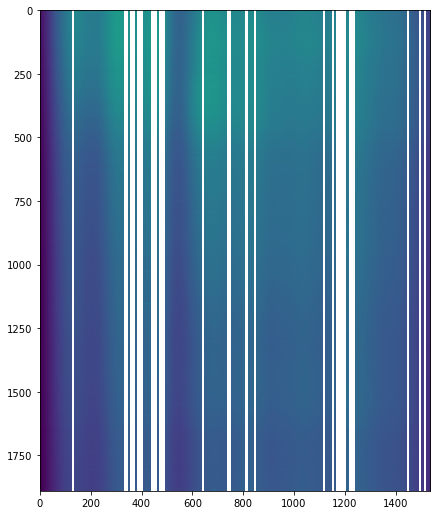

In [436]:
fig = plt.figure(figsize=(7,10))

plt.imshow(masked_data, 
          vmin=0.3*10e6,vmax= 0.3*10e7 ) 

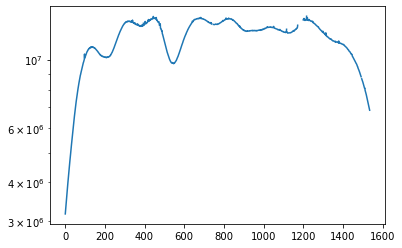

In [437]:
#gets power averaged over time 
powers_avg= ma.mean(masked_data,0)
#creates 1d array of frequency indeces
freq_index= np.arange(0,uv.Nfreqs,1)
#freq = uv.freq_array[0]*1e-6

plt.plot(freq_index,powers_avg)
plt.yscale('log')

In [445]:
def masked_auto_waterfall_lineplot (masked_array,ant,colorbar_min, colorbar_max):
    
    freq = uv.freq_array[0]*1e-6
    fig = plt.figure(figsize=(20,20))

    #can use gridspec instead of saying add_subplot(1,2,1) etc
    gs = gridspec.GridSpec(2, 1, height_ratios=[2,1]) 

    #creates waterfall subplot
    waterfall= plt.subplot(gs[0])
        
    #create time axis
    jd_ax=plt.gca()

    #there are a lot of redundancies in time_array, so to make sure that we have a list
    #of unique times to work with, we start off by making a new array... not doing this will
    #make things get messy. gave me a blank plot at first with a bunch of lines on the side
    #before i did this.
    times= np.unique(uv.time_array)

    #create the plot. uv.get_data will get data from specified antennas
    #colors.LogNorm() puts colors on log scale
    im = plt.imshow(masked_array,norm=colors.LogNorm(), 
                vmin=colorbar_min, vmax=colorbar_max, aspect='auto')
    waterfall.set_title('Waterfall+Lineplot, Antenna '+str(ant))

    # get an array of frequencies in MHz
    #freqs = uv.freq_array[0, :] / 1000000
    #xticks = np.arange(0, len(freqs), 120)
    #plt.xticks(xticks, labels =np.around(freqs[xticks],2))

    jd_ax.set_ylabel('JD Time (days)')

    #makes equally spaced ticks in increments of 100. since we are assuming time is pretty
    #continuous, this will cover all times pretty well if we go from 0 to the length 
    jd_yticks = np.arange(0,len(times),100)
    #set_yticks takes a List of y-axis tick locations. its purpose is to set tick locations
    jd_ax.set_yticks(jd_yticks)
    #this function actually determines what the tickmarks will say.
    jd_ax.set_yticklabels(np.around(times[jd_yticks],2))


    #create second axis
    lst_ax = jd_ax.twinx()
    lst_ax.set_ylabel('LST Time (hour of the day)')

    #lst_array is in radians, and we want it in *hours*.. rad*180/pi = degrees
    #one hour= 15 degrees
    lst_hours = (uv.lst_array*(180/np.pi))/(15)

    #creates array of unique lsts
    lsts= lst_hours.reshape(uv.Ntimes,uv.Nbls)
    lsts = lsts[:,0]

    #set the ticks of the lst axis to match the lst_array in hours
    lst_yticks = np.arange(0,len(lsts),100)
    lst_ax.set_yticks(lst_yticks)
    lst_ax.set_yticklabels(np.around(lsts[lst_yticks],2))

    #gives the lst_axis information about the jd_axis. stuff like the y-dimension of the data. 
    #gets the axes to line up properly. will make it so that the tick-marks lining up, and the 
    #zeroth entry of times[jd_yticks] lining up with the zeroth entry of lsts[lst_yticks]
    lst_ax.set_ylim(jd_ax.get_ylim())

    #makes it so that the second axis does not alter the structure of the figure
    jd_ax.autoscale(False)
    lst_ax.autoscale(False)

    #creates line subplot and positions it according to gs[1]
    line= plt.subplot(gs[1])

    averaged_data= np.abs(np.average(uv.get_data((1,1, uv.polarization_array[0])),0))

    #gets power averaged over time 
    powers_avg= ma.mean(masked_array,0)
    #creates 1d array of frequency indeces
    freq_index= np.arange(0,uv.Nfreqs,1)
    #freq = uv.freq_array[0]*1e-6

    plt.plot(freq_index,powers_avg)
    line.set_yscale('log')
    
    #plt.plot(freq,averaged_data)
    #line.set_yscale('log')
    #line.set_xlabel('Frequency (MHz)')
    #line.set_ylabel('Power')
    #sets the range of the graph to be the same range as waterfall plot
    #line.set_xlim(freq[0],freq[-1])


    #makes waterfall x ticks invisible
    plt.setp(waterfall.get_xticklabels(), visible=False)

    #brings plots together
    plt.subplots_adjust(hspace=.0)


    #pad moves colorbar farther from plot
    cbar = plt.colorbar(im, pad= 0.15, orientation = 'horizontal')
    cbar.set_label('Power -->')
        
    #plt.savefig('/lustre/aoc/projects/hera/amyers/gitrepos/monsterDetection/waterfalls/'+
    #                'WF_LP_ant'+str(ant))
    #plt.show()
    #plt.close()


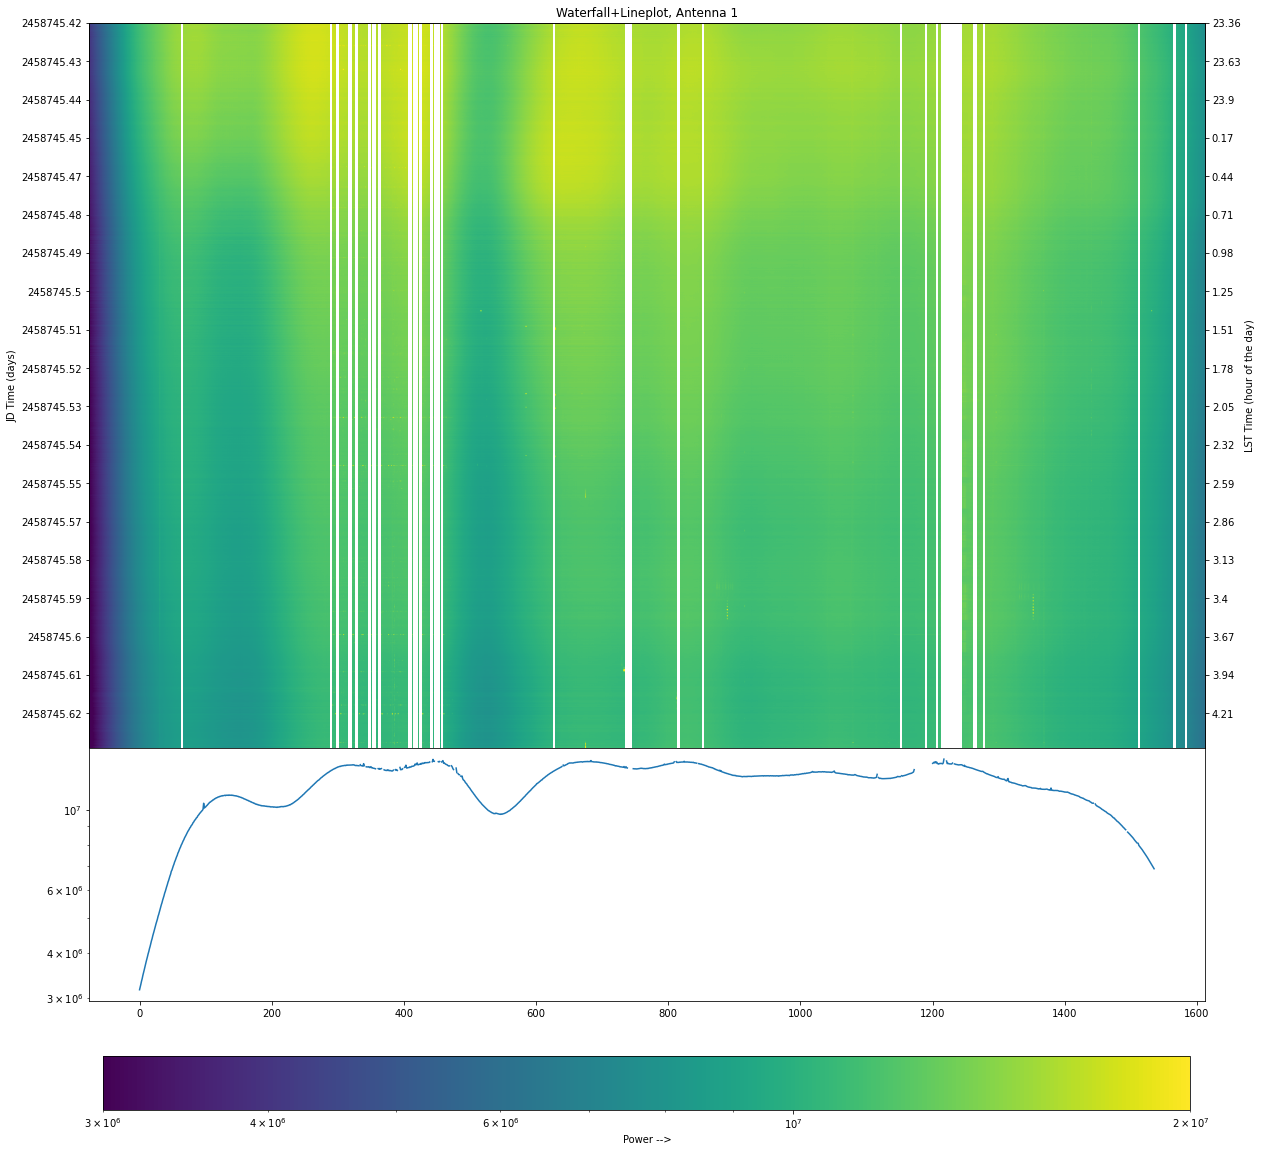

In [447]:
masked_auto_waterfall_lineplot(masked_data,1,0.3*10e6, 0.2*10e7)

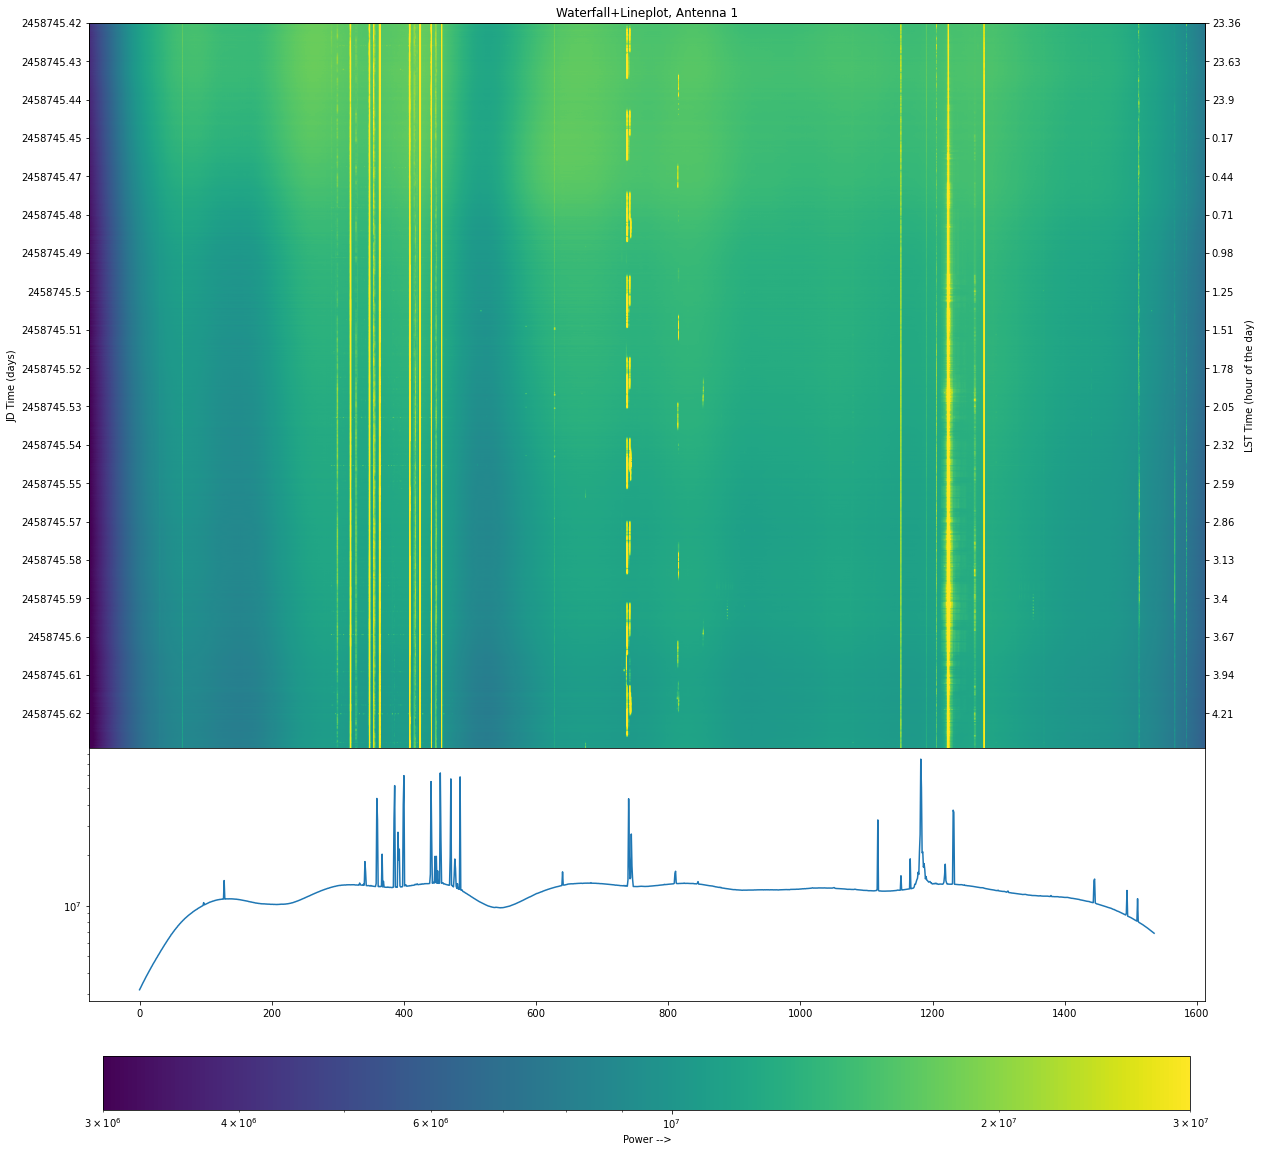

In [448]:
masked_auto_waterfall_lineplot(data_array,1,0.3*10e6, 0.3*10e7)